# Imports

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import copy

# Global Variables

In [2]:
epochs = 500
batch_size = 16
number_of_particles = epochs * 2 * batch_size
dt = 0.1

# Classes

In [3]:
class Particle:
    def __str__(self):
        return "Position: %s, Velocity: %s, Accleration: %s" % (self.position, self.velocity, self.acceleration)
    
    def __repr__(self):
        return "Position: %s, Velocity: %s, Accleration: %s" % (self.position, self.velocity, self.acceleration)
    
    def __init__(self):
        self.position = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) # Position X, Y
        self.velocity = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) # Velocity X, Y
        self.acceleration = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) # Acceleration X, Y
        
    def apply_physics(self,dt):
        nextParticle = copy.deepcopy(self) # Copy to retain initial values
        nextParticle.position += self.velocity * dt
        nextParticle.velocity += self.acceleration * dt
        return nextParticle
    
    def get_list(self):
        return [self.position[0],self.position[1],self.velocity[0], self.velocity[1], self.acceleration[0], self.acceleration[1]]
    
    def get_list_physics(self,dt):
        n = self.apply_physics(dt)
        return [self.position[0],self.position[1],self.velocity[0], self.velocity[1], self.acceleration[0], 
                self.acceleration[1], n.position[0], n.position[1], n.velocity[0], n.velocity[1]]

In [4]:
class GAN:
    def __init__(self,input_size,output_size,dropout=0.4):
        self.input_size = input_size
        self.output_size = output_size
        self.dropout = dropout
        self.generator = self.generator_network()
        self.discriminator = self.discriminator_network()
        self.adverserial = self.adverserial_network()
    
    def discriminator_trainable(self, val):
        self.discriminator.trainable = val
        for l in self.discriminator.layers:
            l.trainable = val
    
    def generator_network(self): # Generator : Object(6) - Dense - Object(4)
        self.g_input = Input(shape=(self.input_size,), name="Generator_Input")
        g = Dense(128, activation='relu')(self.g_input)
        g = Dropout(self.dropout)(g)
        g = Dense(256, activation='relu')(g)
        g = Dropout(self.dropout)(g)
        g = Dense(512, activation='relu')(g)
        g = Dropout(self.dropout)(g)
        g = Dense(256, activation='relu')(g)
        g = Dropout(self.dropout)(g)
        g = Dense(128, activation='relu')(self.g_input)
        g = Dropout(self.dropout)(g)
        self.g_output = Dense(self.output_size, activation='tanh', name="Generator_Output")(g) 
        m = Model(self.g_input, self.g_output, name="Generator")
        return m
    
    def discriminator_network(self): # Discriminator : Object(10) - Dense - Probability
        d_opt = RMSprop(lr=0.000125,decay=6e-8)
        d_input = Input(shape=(self.input_size+self.output_size,), name="Discriminator_Input")
        d = Dense(128, activation='relu')(d_input)
        d = Dense(256, activation='relu')(d)
        d = Dense(512, activation='relu')(d)
        d = Dense(256, activation='relu')(d)
        d = Dense(128, activation='relu')(d)
        d_output = Dense(1, activation='sigmoid', name="Discriminator_Output")(d)
        m = Model(d_input, d_output, name="Discriminator")
        m.compile(loss='binary_crossentropy', optimizer=d_opt)
        return m
    
    def adverserial_network(self): # Adverserial : Object(6) - Generator - Discriminator - Probability
        a_opt = RMSprop(lr=0.0001,decay=3e-8)
        d_input = Concatenate(name="Generator_Input_Output")([self.g_input,self.g_output])
        m=Model(self.g_input, self.discriminator(d_input))
        m.compile(loss='binary_crossentropy', optimizer=a_opt)
        return m
    
    def train_discriminator(self,val):
        self.discriminator.trainable = val
        for l in self.discriminator.layers:
            l.trainable = val
    
    def train(self, adverserial_set, discriminator_set, epochs, batch_size):
        
        losses = {"d":[], "g":[]}

        for i in range(epochs):
            
            batch = discriminator_set[int(i/2*batch_size/2):int((i/2+1)*batch_size/2)] # Gets a batch of real data
            
            for j in adverserial_set[int(i/2*batch_size/2):int((i/2+1)*batch_size/2)]: # Gets a batch of generated data
                n = copy.deepcopy(j)
                p = self.predict(j)
                for e in p:
                    n.append(e)
                batch.append(n)
            
            #self.train_discriminator(True) # Turns on discriminator weights
            
            output = np.zeros(batch_size) # Sets output weight 0 for real and 1 for fakes
            output[int(batch_size/2):] = 1
            
            losses["d"].append(self.discriminator.train_on_batch(np.array(batch), np.array(output))) # Train discriminator
            
            batch = adverserial_set[(i*batch_size):((i+1)*batch_size)] # Gets real data to train generator
            output = np.zeros(batch_size)
            
            #self.train_discriminator(False) # Turns off discriminator weights
            
            losses["g"].append(self.adverserial.train_on_batch(np.array(batch), np.array(output))) # Train generator
            
            print('Epoch %s - Adverserial Loss : %s, Discriminator Loss : %s' % (i+1, losses["g"][-1], losses["d"][-1]))
        
        self.generator.save("Generator.h5")
        self.discriminator.save("Discriminator.h5")
        
        return losses
    
    def predict(self, pred):
        return self.generator.predict(np.array(pred).reshape(-1,6))[0]

# Training Data

In [5]:
training_set = []
actual_set = []

for i in range(number_of_particles):
    p = Particle()
    if(i%2==0):
        training_set.append(p.get_list())
    else:
        actual_set.append(p.get_list_physics(dt))

# Training

In [6]:
network = GAN(input_size=6,output_size=4,dropout=0)

In [7]:
loss = network.train(adverserial_set=training_set,discriminator_set=actual_set,epochs=epochs,batch_size=batch_size)

Epoch 1 - Adverserial Loss : 0.68993413, Discriminator Loss : 0.6928395
Epoch 2 - Adverserial Loss : 0.66143435, Discriminator Loss : 0.68966395
Epoch 3 - Adverserial Loss : 0.6506674, Discriminator Loss : 0.69156027
Epoch 4 - Adverserial Loss : 0.6345487, Discriminator Loss : 0.6851229
Epoch 5 - Adverserial Loss : 0.6190306, Discriminator Loss : 0.6815617
Epoch 6 - Adverserial Loss : 0.60411817, Discriminator Loss : 0.67499703
Epoch 7 - Adverserial Loss : 0.5817479, Discriminator Loss : 0.6683197
Epoch 8 - Adverserial Loss : 0.56560206, Discriminator Loss : 0.6666347
Epoch 9 - Adverserial Loss : 0.5741377, Discriminator Loss : 0.68710524
Epoch 10 - Adverserial Loss : 0.54610217, Discriminator Loss : 0.672557
Epoch 11 - Adverserial Loss : 0.5515704, Discriminator Loss : 0.6653353
Epoch 12 - Adverserial Loss : 0.5424552, Discriminator Loss : 0.6867492
Epoch 13 - Adverserial Loss : 0.52841425, Discriminator Loss : 0.6719169
Epoch 14 - Adverserial Loss : 0.52467513, Discriminator Loss : 0

Epoch 117 - Adverserial Loss : 0.4302489, Discriminator Loss : 0.61337245
Epoch 118 - Adverserial Loss : 0.4279827, Discriminator Loss : 0.6445541
Epoch 119 - Adverserial Loss : 0.45573175, Discriminator Loss : 0.65708464
Epoch 120 - Adverserial Loss : 0.46225488, Discriminator Loss : 0.6396746
Epoch 121 - Adverserial Loss : 0.44190186, Discriminator Loss : 0.6420307
Epoch 122 - Adverserial Loss : 0.46701294, Discriminator Loss : 0.6434755
Epoch 123 - Adverserial Loss : 0.45194924, Discriminator Loss : 0.6441387
Epoch 124 - Adverserial Loss : 0.45976266, Discriminator Loss : 0.6495506
Epoch 125 - Adverserial Loss : 0.43895495, Discriminator Loss : 0.63236755
Epoch 126 - Adverserial Loss : 0.41991127, Discriminator Loss : 0.63636404
Epoch 127 - Adverserial Loss : 0.45418686, Discriminator Loss : 0.67075235
Epoch 128 - Adverserial Loss : 0.50263035, Discriminator Loss : 0.6377561
Epoch 129 - Adverserial Loss : 0.47822657, Discriminator Loss : 0.6191629
Epoch 130 - Adverserial Loss : 0.44

Epoch 230 - Adverserial Loss : 0.4969196, Discriminator Loss : 0.58613336
Epoch 231 - Adverserial Loss : 0.47068602, Discriminator Loss : 0.5865829
Epoch 232 - Adverserial Loss : 0.52875483, Discriminator Loss : 0.61925715
Epoch 233 - Adverserial Loss : 0.5240176, Discriminator Loss : 0.6085472
Epoch 234 - Adverserial Loss : 0.5204061, Discriminator Loss : 0.58244824
Epoch 235 - Adverserial Loss : 0.48983783, Discriminator Loss : 0.5583605
Epoch 236 - Adverserial Loss : 0.53697085, Discriminator Loss : 0.587798
Epoch 237 - Adverserial Loss : 0.5250551, Discriminator Loss : 0.6093218
Epoch 238 - Adverserial Loss : 0.5272552, Discriminator Loss : 0.5817112
Epoch 239 - Adverserial Loss : 0.5460291, Discriminator Loss : 0.61881137
Epoch 240 - Adverserial Loss : 0.5046903, Discriminator Loss : 0.6542069
Epoch 241 - Adverserial Loss : 0.5139593, Discriminator Loss : 0.6180856
Epoch 242 - Adverserial Loss : 0.4942582, Discriminator Loss : 0.62091786
Epoch 243 - Adverserial Loss : 0.5101025, D

Epoch 348 - Adverserial Loss : 0.57391334, Discriminator Loss : 0.6556354
Epoch 349 - Adverserial Loss : 0.57983744, Discriminator Loss : 0.59829575
Epoch 350 - Adverserial Loss : 0.56457585, Discriminator Loss : 0.6049141
Epoch 351 - Adverserial Loss : 0.5145416, Discriminator Loss : 0.54946864
Epoch 352 - Adverserial Loss : 0.5335087, Discriminator Loss : 0.5293221
Epoch 353 - Adverserial Loss : 0.56736135, Discriminator Loss : 0.6280614
Epoch 354 - Adverserial Loss : 0.60682523, Discriminator Loss : 0.5745943
Epoch 355 - Adverserial Loss : 0.54181075, Discriminator Loss : 0.5325807
Epoch 356 - Adverserial Loss : 0.5998812, Discriminator Loss : 0.57993954
Epoch 357 - Adverserial Loss : 0.53707576, Discriminator Loss : 0.5656924
Epoch 358 - Adverserial Loss : 0.56403726, Discriminator Loss : 0.572779
Epoch 359 - Adverserial Loss : 0.5631242, Discriminator Loss : 0.6175618
Epoch 360 - Adverserial Loss : 0.5736669, Discriminator Loss : 0.60747325
Epoch 361 - Adverserial Loss : 0.5465219

Epoch 463 - Adverserial Loss : 0.64476657, Discriminator Loss : 0.5894046
Epoch 464 - Adverserial Loss : 0.6788615, Discriminator Loss : 0.5719651
Epoch 465 - Adverserial Loss : 0.61312044, Discriminator Loss : 0.5584748
Epoch 466 - Adverserial Loss : 0.5457104, Discriminator Loss : 0.5176487
Epoch 467 - Adverserial Loss : 0.65067536, Discriminator Loss : 0.5704508
Epoch 468 - Adverserial Loss : 0.62563884, Discriminator Loss : 0.62129855
Epoch 469 - Adverserial Loss : 0.68691885, Discriminator Loss : 0.62204194
Epoch 470 - Adverserial Loss : 0.61463714, Discriminator Loss : 0.5400488
Epoch 471 - Adverserial Loss : 0.66334426, Discriminator Loss : 0.49380594
Epoch 472 - Adverserial Loss : 0.6338473, Discriminator Loss : 0.548424
Epoch 473 - Adverserial Loss : 0.6352856, Discriminator Loss : 0.51378906
Epoch 474 - Adverserial Loss : 0.6537573, Discriminator Loss : 0.49764973
Epoch 475 - Adverserial Loss : 0.59065616, Discriminator Loss : 0.52403784
Epoch 476 - Adverserial Loss : 0.54441

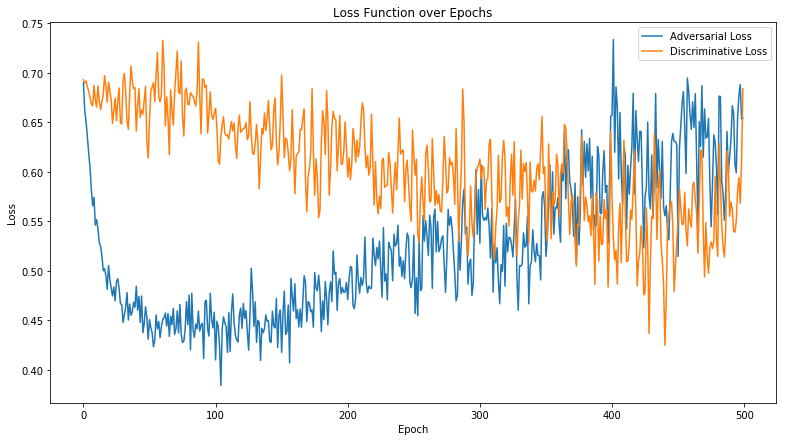

In [8]:
fig = plt.figure(figsize=(13,7))
plt.title("Loss Function over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss["g"], label="Adversarial Loss")
plt.plot(loss["d"], label="Discriminative Loss")
plt.legend()
plt.show()

In [9]:
network.predict([0.1,0.2,0.1,0.1,0.1,0.1])

array([5.2618794e-05, 2.0959198e-03, 2.6658386e-02, 1.2531765e-02],
      dtype=float32)

In [10]:
network.generator.summary()
network.discriminator.summary()
network.adverserial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator_Input (InputLayer) (None, 6)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               896       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
Generator_Output (Dense)     (None, 4)                 516       
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Discriminator_Input (InputLa (None, 10)                0         
_________________________________________________________________
dense_5 